### Assignment 2
----
COMP 7745 Machine Learning <br><br>
Univerity of Memphis <br>
Fall 2022 <br>

@author <br>
Bereket Kebede <br>

----


## Support Vector Machines with PCA


# **Introduction**

One of the important ways humans display emotions is through facial expressions. Facial expression recognition is one of the most powerful, natural and immediate means for human beings to communicate their emotions and intensions. Humans can be in some circumstances restricted from showing their emotions, such as hospitalized patients, or due to deficiencies; hence, better recognition of other human emotions will lead to effective communication. Automatic human emotion recognition has received much attention recently with the introduction of IOT and smart environments at hospitals, smart homes and smart cities. Intelligent personal assistants (IPAs), such as Siri, Alexia, Cortana and others, use natural language processing to communicate with humans, but when augmented with emotions, it increases the level of effective communication and human-level intelligence.

![](https://programmathically.com/wp-content/uploads/2021/08/pca-2-dimensions.png)

**Import libraries**

In [1]:
#################################################
# import libraries

import numpy as np 
from tqdm import tqdm
import cv2
import os
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
init_notebook_mode(connected=True)
RANDOM_SEED = 123

# **Load Data and Plot Samples**

In [2]:
#################################################
# load data

TRAIN_DIR = ('Training/Training/')
TEST_DIR = ('Testing/Testing/')

In [3]:
#################################################
# load data from a given directory
def load_data(dir_path, IMG_SIZE):
   
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    img = img.astype('float32') / 255
                    resized = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
                    X.append(resized)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [4]:
IMG_SIZE= (48, 48)

In [5]:
X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:21<00:00, 13.54s/it]


28273 images loaded from Training/Training/ directory.


In [6]:
train_labels

{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}

In [7]:
X_test, y_test, test_labels = load_data(TEST_DIR,IMG_SIZE)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:20<00:00,  3.47s/it]

7067 images loaded from Testing/Testing/ directory.


### Visualization

In [8]:
#################################################
# visualize data samples
def plot_samples(X, y, labels_dict, n=50):
   
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(10,2))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle(labels_dict[index])
        plt.show()

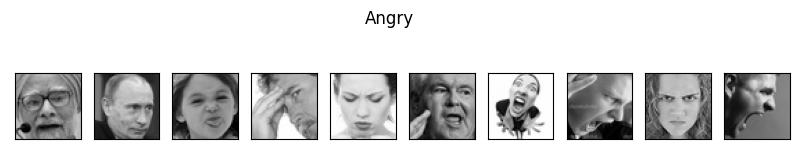

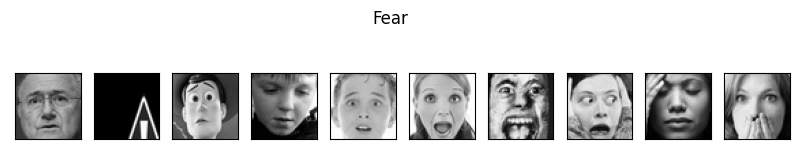

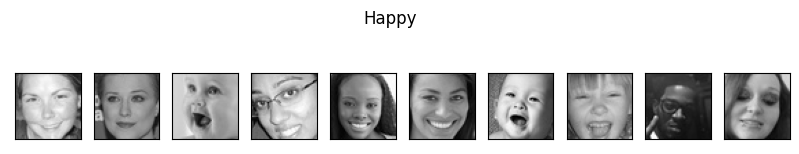

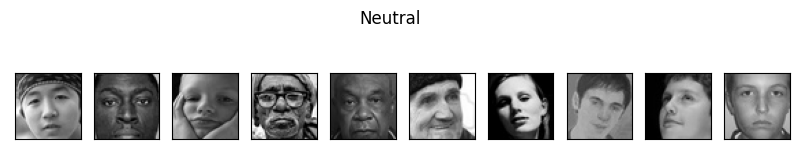

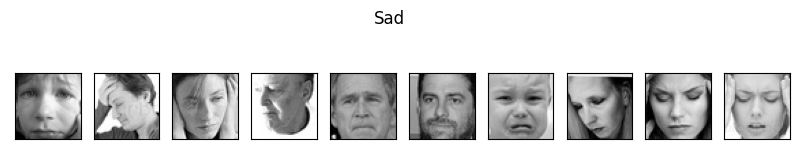

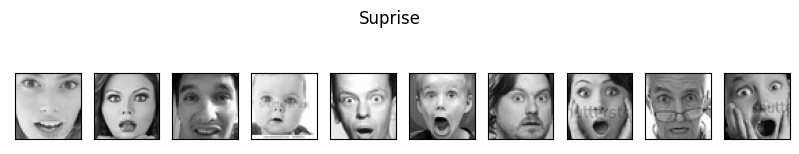

In [9]:
plot_samples(X_train, y_train, train_labels, 10)

**Encoding Classes**

Using the method to_categorical(), a numpy array (or) a vector which has integers that represent different categories, can be converted into a numpy array (or) a matrix which has binary values and has columns equal to the number of categories in the data.

In [10]:
from keras.utils.np_utils import to_categorical
Y_train = to_categorical(y_train, num_classes=6)
Y_train.shape

(28273, 6)

In [11]:
Y_test = to_categorical(y_test, num_classes=6)
Y_test.shape

(7067, 6)

### **Model Building**


In [19]:
#################################################
# import libraries

from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [13]:
print (X_train.shape)
print (X_test.shape)

(28273, 48, 48, 3)
(7067, 48, 48, 3)


In [14]:
X_train_new = X_train[:,:,:,0]
X_test_new = X_test[:,:,:,0]

In [15]:
nsamples, nx, ny,v = X_train.shape
X_train_newer = X_train_new.reshape((nsamples,nx*ny))

In [16]:
nsamples, nx, ny,v = X_test.shape
X_test_newer = X_test_new.reshape((nsamples,nx*ny))

In [17]:
print (X_train_newer.shape)
print (X_test_newer.shape)

(28273, 2304)
(7067, 2304)


### Principal Component Analysis (PCA)

In [79]:
%%time

#################################################
# Train PCA

pca = PCA(n_components=2000)
scaler = StandardScaler()

X_train_newest = pca.fit_transform(X_train_newer)
X_test_newest = pca.transform(X_test_newer)

X_train_4 = scaler.fit_transform(X_train_newest)
X_test_4 = scaler.transform(X_test_newest)

CPU times: total: 2min 9s
Wall time: 13.7 s


### Radial Kernel SVM


Radial kernel support vector machine is a good approach when the data is not linearly separable. The idea behind generating non-linear decision boundaries is that we need to do some nonlinear transformations on the features X
i
 which transforms them into a higher dimensional space.

In [80]:
%%time

# becareful not to re-run
# Radial Basis Kernel-Support Vector Machine (Kernel-SVM) based classification model for facial expression recognition
clf = svm.SVC(kernel='rbf')
clf.fit(X_train_4, y_train)

CPU times: total: 23min 39s
Wall time: 23min 40s


SVC()

In [81]:
y_pred = clf.predict(X_test_4)

In [82]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.3896985991226829


In [73]:
print("Precision Score : ",metrics.precision_score(y_test, y_pred, average='micro'))
print("Recall Score : ",metrics.recall_score(y_test, y_pred, average='micro'))

Precision Score :  0.3190887222300835
Recall Score :  0.3190887222300835


### References

https://www.kaggle.com/code/basel99/facial-recognition   <br>
 
https://www.kaggle.com/code/faressayah/support-vector-machine-pca-tutorial-for-beginner  <br>

https://datascienceplus.com/radial-kernel-support-vector-classifier/  <br>